# QuantLab

This notebook is a companion to the material presented during the lecture held on Friday, 29th October 2021, in the scope of the "Architecture and Platforms for Artificial Intelligence" (APAI) course offered by the University of Bologna.

The notebook is structured into three parts:
* [**introduction to PyTorch**](#sec:pytorch); this section is a brief tutorial on using the PyTorch deep learning framework to describe and train DNNs;
* [**training QNNs with the PACT algorithm**](#sec:float2fake); this section shows how to train mixed-precision QNNs using the `quantlib` Python package, an add-on for PyTorch developed to support the training and manipulation of QNNs;
* [**exporting trained QNNs to integerised ONNX IRs**](#sec:fake2true); this section shows how to use `quantlib` to convert a trained PyTorch QNN into an ONNX intermediate representation specifically annotated to be processed by DORY, a deployment tool targetting the PULP platform.


To facilitate the understanding of the code, it is useful to annotate functions with the types of their inputs and outputs.
Therefore, in this notebook we will extensively use the `typing` Python package.


In [1]:
import typing
from typing import Union, Tuple, List, Dict


<a id='sec:pytorch'></a>
## Introduction to PyTorch

In this section, we will describe and train a simple deep convolutional neural network using PyTorch.


Let's start by defining a fully feedforward, VGG-like network topology.


In [2]:
import torch
import torch.nn as nn


_CONFIGS = {
    'VGG8':  ['M', 256, 256, 'M', 512, 512, 'M'],
    'VGG9':  [128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'VGG11': [128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
}


class VGG(nn.Module):

    def __init__(self, config: str) -> None:

        super(VGG, self).__init__()

        self.pilot      = self._make_pilot(config)
        self.features   = self._make_features(config)
        self.avgpool    = self._make_avgpool(config)
        self.classifier = self._make_classifier(config)

        self._initialize_weights()

    @staticmethod
    def _make_pilot(config: str) -> nn.Sequential:

        out_channels = 128
        modules = []

        modules += [nn.Conv2d(3, out_channels, kernel_size=3, padding=1, bias=False)]
        modules += [nn.BatchNorm2d(out_channels)]
        modules += [nn.ReLU(inplace=True)]

        return nn.Sequential(*modules)

    @staticmethod
    def _make_features(config: str) -> nn.Sequential:

        in_channels = 128
        modules = []

        for v in _CONFIGS[config]:
            if v == 'M':
                modules += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                out_channels = v
                modules += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)]
                modules += [nn.BatchNorm2d(out_channels)]
                modules += [nn.ReLU(inplace=True)]
                in_channels = out_channels

        return nn.Sequential(*modules)

    @staticmethod
    def _make_avgpool(config: str):
        return nn.AdaptiveAvgPool2d((4, 4))

    @staticmethod
    def _make_classifier(config: str) -> nn.Sequential:

        modules = []

        modules += [nn.Linear(512 * 4 * 4, 1024, bias=False)]
        modules += [nn.BatchNorm1d(1024)]
        modules += [nn.ReLU(inplace=True)]
        modules += [nn.Linear(1024, 1024, bias=False)]
        modules += [nn.BatchNorm1d(1024)]
        modules += [nn.ReLU(inplace=True)]
        modules += [nn.Linear(1024, 10)]

        return nn.Sequential(*modules)

    def _initialize_weights(self):

        for m in self.modules():

            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.pilot(x)
        x = self.features(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)  # https://stackoverflow.com/questions/57234095/what-is-the-difference-of-flatten-and-view-1-in-pytorch

        x = self.classifier(x)

        return x


A first sanity check: we verify that the network can process CIFAR-10 data points (see below for details on CIFAR-10).


In [3]:
device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

# create the network
network = VGG('VGG9')
network = network.to(device=device)  # REMEMBER: place the parameters of the 'Module' on the device that guarantees the best performance
print(network)
print()

# verify that it can process tensor data
network.eval()  # REMEMBER: before evaluating a network, freeze the batch-normalisation and dropout parameters
dummy_x = torch.randn(1, 3, 32, 32).to(device=device)
dummy_y = network(dummy_x)

print("`dummy_x` shape: {}".format(dummy_x.shape))
print("`dummy_y` shape: {}".format(dummy_y.shape))


VGG(
  (pilot): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (features): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=

/home/spmatteo/anaconda3/envs/quantlab/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### The CIFAR-10 data set

The ten-classes Canadian institute for advanced research (CIFAR-10) data set contains $60000$ images depicting objects belonging to ten different classes.
Each image has a resolution of $32 \times 32$ pixels, and is encoded using the RGB color model.

Each class is represented by exactly $60000 / 10 = 6000$ images, $5000$ of which belong to the training partition and $1000$ of which belong to the validation partition.
Overall, the training partition contains $50000$ data points, whereas the validation partition contains $10000$.


We start by downloading the data set.
Then, we create two distinct PyTorch `Dataset` objects: one for the training partition and one for the validation partition.

`Dataset`s are PyTorch abstractions to map files (stored on disk) to objects in the space allocated to the Python process executing PyTorch.
`Dataset`s can be attached transforms (`transform` for the input points, `target_transform` for the labels), object representing pre-processing functions that should be applied to the raw data points before they are returned to the Python process space.
A `Dataset` object can be queried for a data point by passing an integer index to the `__getitem__` method; when this happens, the `Dataset` objects looks up the path of the file from an internal look-up table, applies a user-defined function to load the file into a raw Python object, and finally applies the `transform`s defined by the user.


In [4]:
import os
import pickle
import torchvision
import torchvision.transforms as transforms


def create_cifar10_dir_data() -> os.PathLike:
    """Create a directory where `torchvision` should store CIFAR-10 data."""
    dir_data = os.path.join(os.curdir, 'data_cifar10')
    if not os.path.isdir(dir_data):
        os.makedirs(dir_data, exist_ok=True)

    return dir_data
    

def load_cifar10_data_set(dir_data: os.PathLike, train: bool) -> torch.utils.data.Dataset:
    
    # define the pre-processing transform that will be applied to each data point
    transform_list = []
    if train:
        transform_list += [transforms.RandomHorizontalFlip()]
        transform_list += [transforms.ToTensor()]
    else:
        transform_list += [transforms.ToTensor()]
    transform = transforms.Compose(transform_list)
    
    # load the data into `Dataset` objects (PyTorch exposes specialised loader objects for CIFAR-10: https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.CIFAR10)
    data_set = torchvision.datasets.CIFAR10(root=dir_data, train=train, download=True, transform=transform)

    return data_set


def load_cifar10_int2label(dir_data: os.PathLike) -> Dict[int, str]:

    # see https://www.cs.toronto.edu/~kriz/cifar.html to understand how the CIFAR-10 data is organised
    labels_file = os.path.join(dir_data, 'cifar-10-batches-py', 'batches.meta')
    with open(labels_file, 'rb') as fp:
        labels = {i: name.capitalize() for i, name in enumerate(pickle.load(fp)['label_names'])}
    
    return labels


A sanity check: we verify that the `Dataset`s actually contain the number of data points that we expect from CIFAR-10, and have a look at their classes.


In [5]:
dir_data   = create_cifar10_dir_data()
train_data = load_cifar10_data_set(dir_data, train=True)
valid_data = load_cifar10_data_set(dir_data, train=False)
int2label  = load_cifar10_int2label(dir_data)

print()
print("Training data set contains {} data points.".format(len(train_data)))
print("Validation data set contains {} data points.".format(len(valid_data)))
print()
print("CIFAR-10 classes: ")
for i, name in int2label.items():
    print("{}: {}".format(i, name))
    

Files already downloaded and verified
Files already downloaded and verified

Training data set contains 50000 data points.
Validation data set contains 10000 data points.

CIFAR-10 classes: 
0: Airplane
1: Automobile
2: Bird
3: Cat
4: Deer
5: Dog
6: Frog
7: Horse
8: Ship
9: Truck


Visualising the data you are working on is usually motivating and educational.
Therefore, we define a utility function that can show us labelled images sampled at random from one of the two partitions of the CIFAR-10 data set.


In [6]:
import random
import matplotlib.pyplot as plt


def show_random_cifar10_image(data_set: torch.utils.data.Dataset, int2label: Dict[int, str]) -> None:
    x, y = data_set.__getitem__(random.randrange(0, len(data_set)))  # https://docs.python.org/3/library/random.html#random.randrange
    plt.imshow(x.permute(1, 2, 0))
    plt.title(int2label[y])  # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.title.html
    plt.show()


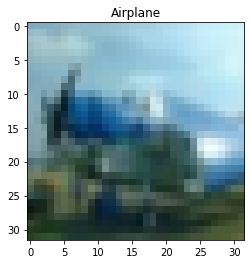

In [7]:
# REPLAY: this cell should show different CIFAR-10 data points
show_random_cifar10_image(valid_data, int2label)

The cost of training DNNs on real hardware can be optimised by means of mini-batching.
Indeed, since each data point is processed independently of the others we can rewrite the collection of vector-matrix products
$$(\mathbf{x}^{(i-1, 1)} W^{(i)}, \dots, \mathbf{x}^{(i, K)} W^{(i)})$$
as a single matrix-matrix product
$$X^{(i-1)} W^{(i)} \,,$$
where $X^{(i-1)}_{(k)} := \mathbf{x}^{(i-1, k)}, k = 1, \dots, K$.
This rewriting allows minimising the number of memory transactions on host-device computing systems (e.g., those using GPGPUs) and maximising the utilisation of data movement components, as well as minimising the number of idle processing elements on parallel hardware (e.g., the CUDA cores of NVidia GPGPUs).

The PyTorch mechanism to create mini-batches of data points consists of two components:
* a `Sampler`, which implements the policy to split the complete data set into mini-batches; for instance, at training time it is important that the distribution of data inside a mini-batch is as heterogeneous as possible, to avoid overfitting the model's parameters to just a few classes;
* a `DataLoader`, which queries the `Sampler` for the indices of the data points that will compose the next batch, reads the associated data points from the `Dataset` (which applies the assigned pre-processing `transform` to each data point as soon as it is loaded from disk), and composes them into batches ready to be fed to the PyTorch DNN that we want to train.


In [8]:
def create_data_loader(data_set: torch.utils.data.Dataset, train: bool, batch_size: int) -> torch.utils.data.DataLoader:
    
    if train:
        sampler = torch.utils.data.RandomSampler(data_set)
    else:
        sampler = torch.utils.data.SequentialSampler(data_set)
        
    loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, sampler=sampler)
    
    return loader


A sanity check: we verify that the `DataLoader`s actually return `Tensor`s of the size that we expect.


In [9]:
bs = 64
train_loader = create_data_loader(train_data, True,  bs)
valid_loader = create_data_loader(valid_data, False, bs)


bx, by = next(iter(train_loader))
print("Shape of input `torch.Tensor`: {}".format(bx.shape))
print("Shape of label array: {}".format(len(by)))


Shape of input `torch.Tensor`: torch.Size([64, 3, 32, 32])
Shape of label array: 64


### Training DNNs


#### DNN training as an optimisation problem.

In principle, the optimal DNN $f^{*}$ minimises the loss functional with respect to the true data distribution $\mu$:
$$f^{*} := \underset{f \in \mathcal{F}}{\arg\min} \int_{X \times Y} \ell(f(x), y) \, d\mu(x, y) \,.$$
Here, $\ell : Y \times Y \to \mathbb{R}^{+}_{0}$ is the loss function, a function which should satisfy $\ell(f(x), y) = 0 \iff f(x) = y$.

Since the DNN $f$ is parametrised by $\theta \in \Theta$, we can rewrite this functional optimisation problem as the minimisation of an integral equation that depends on $\theta$:
$$\theta^{*} := \underset{\theta \in \Theta}{\arg\min} \int_{X \times Y} \ell(f(\theta, x), y) \, d\mu(x, y) \,.$$

One of the standard strategies to minimise differentiable functions is using gradient descent, where the gradient
$$g^{t} := \nabla_{\theta} \left( \int_{X \times Y} \ell(f(\theta^{t}, x), y) \, d\mu(x, y) \right)$$
plays the role of the learning signal.
<!--- Under certain hypothesis, exchangeability theorems (e.g., Fubini's theorem) can be applied to bring the gradient under the integral sign:
$$g^{t} = \eta \int_{X \times Y} \left( \nabla_{\theta} \ell(f(\theta^{t}, x), y) \right) \, d\mu(x, y) \,.$$ --->

Apart from technicalities, the most important issue of this formalism lies in the fact that the true data distribution $\mu$ is unknown.
In practical cases, the true measure is approximated by the empirical measure associated with an available, finite data set $\mathcal{D} = ((x^{(1)}, y^{(1)}), \dots, (x^{(N)}, y^{(N)}))$:
$$\mu \approx m := \frac{1}{N} \sum_{n=1}^{N} \delta_{(x^{(n)}, y^{(n)})} \,.$$

When plugged into the loss functional, this empirical measure yields the following learning signal:
\begin{align*}
    g^{t}
    &= \nabla_{\theta} \left( \frac{1}{N} \sum_{n=1}^{N} \ell(f(\theta^{t}, x^{(n)}), y^{(n)}) \right) \\
    &= \frac{1}{N} \sum_{n=1}^{N} \left( \nabla_{\theta} \ell(f(\theta^{t}, x^{(n)}), y^{(n)}) \right) \,.
\end{align*}

Note that when the data set $\mathcal{D}$ is fixed, the value $g^{t}$ of the gradient computed with respect to a specific value $\theta^{t}$ of the variable is deterministic; however, the values of $g$ computed for different values of $\theta$ can still differ.


#### Learning rules for DNNs

Gradient descent optimisation algorithms are usually iterative, meaning that the target variable is optimised from an initial condition $\theta^{0}$ to a final condition $\theta^{T}$ with the hope that $\theta^{T} \approx \theta^{*}$.
In the scope of machine learning, the update rule that describes how to go from $\theta^{t}$ to $\theta^{t+1}$ (i.e., the one-step evolution of the system), is called the learning rule.

Several gradient-based learning rules have been proposed to train DNNs.
The simplest one is stochastic gradient descent (SGD).
In this case, the idea is to approximate $\mu$ with a different empirical distribution at each iteration:
$$\mu \approx m^{t} := \frac{1}{B} \sum_{b=1}^{B} \delta_{(x^{(t, b)}, y^{(t, b)})} \,;$$
the collection $((x^{(t, 1)}, y^{(t, 1)}), \dots, (x^{(t, B)}, y^{(t, B)}))$ is called the $t$-th mini-batch, and it is sampled from the complete data set $\mathcal{D}$ ($1 \leq B \ll N$).
Due to this mini-batch sampling, $g$ can take on different values even when computed for the same value of the variable $\theta$; in other words, the dependency of $g^{t}$ on $\theta^{t}$ is stochastic, not deterministic, hence the method's name.
The update rule then is as simple as
$$\theta^{t+1} = \theta^{t} - \eta g^{t} \,;$$
accordingly, the update is $\Delta \theta^{t} := \theta^{t+1} - \theta^{t} = - \eta g^{t}$.

Note that gradients and updates are two different concepts: updates are computed using gradients, but gradients do not define updates by themselves.


#### Optimisation in Pytorch

PyTorch implements loss functions as specific `Module`s.
Some loss `Module`s automatically compute the average value of the loss function with respect to all the data points in a mini-batch; others do not do it automatically.

It is possible to compute gradients using reverse-mode automatic differentiation (also known as back-propagation) with a simple call to the `backward` method of the `Tensor` holding the aggregated loss value.
The gradients of the parameter and feature `Tensor`s are stored in specific `grad` attributes attached to the corresponding `Tensor` objects.

The `torch.optim` module implements `Optimizer` objects associated with the most popular SGD variants (vanilla SGD, RMSProp, Adam, ...).
Remember: `Optimizer`s do not compute gradients; `Optimizer`s have a `step` method that uses gradients $g^{t}$ to compute updates $\Delta \theta^{t}$ and apply them to the parameter `Tensor`s.

Multiple calls to `backward` on the `Tensor` holding the loss value accumulate gradients in the `grad` attributes of parameter and feature `Tensor`s.
Therefore, it is important to remember to zero-out the gradients stored in `grad` attributes after every call to the `step` method of the chosen `Optimizer`, otherwise the "gradient" used by the `Optimizer` will not correspond to the correct gradient that it is supposed to use.

<!--- Sometimes, forgetting to reset the gradients to zero might prevent the network from learning: indeed, if we suppose that gradients follow a multi-dimensional normal distribution, their sum will eventually zero out, leading to vanishing gradients in the span of a few training iterations. --->


In [10]:
import torch.optim as optim


loss_fn   = nn.CrossEntropyLoss()
optimiser = optim.Adam(network.parameters(), lr=0.001)


In [11]:
def fit(device:       torch.device,
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader,
        network:      nn.Module,
        loss_fn:      nn.Module,
        optimiser:    torch.optim.Optimizer,
        n_epochs:     int) -> None:

    for i_epoch in range(0, n_epochs):
    
        # training pass
        network.train()  # REMEMBER: before training a network, release the batch-normalisation and dropout parameters
        optimiser.zero_grad()

        for i_batch, (x, y_gt_int) in enumerate(train_loader):

            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)

            y_pr       = network(x)
            loss_value = loss_fn(y_pr, y_gt_int)

            loss_value.backward()  # back-propagation using torch's `autograd`
            optimiser.step()
            optimiser.zero_grad()

            print("Epoch[{:02d}/{:02d}] | Iteration[{:04d}/{:04d}] - Loss value: {}".format(i_epoch, n_epochs, i_batch, len(train_loader), loss_value.item()))

        # validation pass
        network.eval()  # REMEMBER: before evaluating a network, freeze the batch-normalisation and dropout parameters
        correct = 0

        for x, y_gt_int in valid_loader:
            
            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)

            y_pr     = network(x)
            y_pr_int = y_pr.argmax(axis=1)  # the position of the neuron with the highest score encodes the predicted class

            correct += torch.sum(y_pr_int == y_gt_int).item()

        print("Epoch[{:02d}/{:02d}] - Validation accuracy: {:6.2f}%".format(i_epoch, n_epochs, 100.0 * correct / len(valid_loader.dataset)))


We can now train our first training epoch!


In [12]:
n_epochs = 1
fit(device, train_loader, valid_loader, network, loss_fn, optimiser, n_epochs)

Epoch[00/01] | Iteration[0000/0782] - Loss value: 2.2902233600616455
Epoch[00/01] | Iteration[0001/0782] - Loss value: 2.168121576309204
Epoch[00/01] | Iteration[0002/0782] - Loss value: 1.9841877222061157
Epoch[00/01] | Iteration[0003/0782] - Loss value: 2.174591541290283
Epoch[00/01] | Iteration[0004/0782] - Loss value: 2.1853742599487305
Epoch[00/01] | Iteration[0005/0782] - Loss value: 1.8999896049499512
Epoch[00/01] | Iteration[0006/0782] - Loss value: 1.9005472660064697
Epoch[00/01] | Iteration[0007/0782] - Loss value: 1.9861276149749756
Epoch[00/01] | Iteration[0008/0782] - Loss value: 2.0047085285186768
Epoch[00/01] | Iteration[0009/0782] - Loss value: 1.9111617803573608
Epoch[00/01] | Iteration[0010/0782] - Loss value: 1.7197151184082031
Epoch[00/01] | Iteration[0011/0782] - Loss value: 1.9780986309051514
Epoch[00/01] | Iteration[0012/0782] - Loss value: 1.7935079336166382
Epoch[00/01] | Iteration[0013/0782] - Loss value: 1.9482579231262207
Epoch[00/01] | Iteration[0014/0782] 

Epoch[00/01] | Iteration[0122/0782] - Loss value: 1.613304853439331
Epoch[00/01] | Iteration[0123/0782] - Loss value: 1.3722941875457764
Epoch[00/01] | Iteration[0124/0782] - Loss value: 1.3144620656967163
Epoch[00/01] | Iteration[0125/0782] - Loss value: 1.570178747177124
Epoch[00/01] | Iteration[0126/0782] - Loss value: 1.1697155237197876
Epoch[00/01] | Iteration[0127/0782] - Loss value: 1.1758521795272827
Epoch[00/01] | Iteration[0128/0782] - Loss value: 1.388213038444519
Epoch[00/01] | Iteration[0129/0782] - Loss value: 1.460591435432434
Epoch[00/01] | Iteration[0130/0782] - Loss value: 1.2097171545028687
Epoch[00/01] | Iteration[0131/0782] - Loss value: 1.2693395614624023
Epoch[00/01] | Iteration[0132/0782] - Loss value: 1.2584985494613647
Epoch[00/01] | Iteration[0133/0782] - Loss value: 1.5160207748413086
Epoch[00/01] | Iteration[0134/0782] - Loss value: 1.3214702606201172
Epoch[00/01] | Iteration[0135/0782] - Loss value: 1.091464877128601
Epoch[00/01] | Iteration[0136/0782] - L

Epoch[00/01] | Iteration[0246/0782] - Loss value: 1.3161791563034058
Epoch[00/01] | Iteration[0247/0782] - Loss value: 1.1851446628570557
Epoch[00/01] | Iteration[0248/0782] - Loss value: 1.01583731174469
Epoch[00/01] | Iteration[0249/0782] - Loss value: 1.029046893119812
Epoch[00/01] | Iteration[0250/0782] - Loss value: 1.2590526342391968
Epoch[00/01] | Iteration[0251/0782] - Loss value: 1.2923450469970703
Epoch[00/01] | Iteration[0252/0782] - Loss value: 1.1694283485412598
Epoch[00/01] | Iteration[0253/0782] - Loss value: 1.2467738389968872
Epoch[00/01] | Iteration[0254/0782] - Loss value: 1.2115020751953125
Epoch[00/01] | Iteration[0255/0782] - Loss value: 1.0140451192855835
Epoch[00/01] | Iteration[0256/0782] - Loss value: 1.1373069286346436
Epoch[00/01] | Iteration[0257/0782] - Loss value: 1.1203020811080933
Epoch[00/01] | Iteration[0258/0782] - Loss value: 1.3025286197662354
Epoch[00/01] | Iteration[0259/0782] - Loss value: 1.174484133720398
Epoch[00/01] | Iteration[0260/0782] - 

Epoch[00/01] | Iteration[0366/0782] - Loss value: 1.360675573348999
Epoch[00/01] | Iteration[0367/0782] - Loss value: 0.8469610214233398
Epoch[00/01] | Iteration[0368/0782] - Loss value: 1.0519758462905884
Epoch[00/01] | Iteration[0369/0782] - Loss value: 0.7542871236801147
Epoch[00/01] | Iteration[0370/0782] - Loss value: 0.9744110107421875
Epoch[00/01] | Iteration[0371/0782] - Loss value: 1.0060029029846191
Epoch[00/01] | Iteration[0372/0782] - Loss value: 1.2373478412628174
Epoch[00/01] | Iteration[0373/0782] - Loss value: 1.0689982175827026
Epoch[00/01] | Iteration[0374/0782] - Loss value: 0.906174898147583
Epoch[00/01] | Iteration[0375/0782] - Loss value: 1.2258981466293335
Epoch[00/01] | Iteration[0376/0782] - Loss value: 0.8119885921478271
Epoch[00/01] | Iteration[0377/0782] - Loss value: 0.9848148226737976
Epoch[00/01] | Iteration[0378/0782] - Loss value: 1.1006886959075928
Epoch[00/01] | Iteration[0379/0782] - Loss value: 1.036145567893982
Epoch[00/01] | Iteration[0380/0782] -

Epoch[00/01] | Iteration[0486/0782] - Loss value: 0.9530360698699951
Epoch[00/01] | Iteration[0487/0782] - Loss value: 1.2505714893341064
Epoch[00/01] | Iteration[0488/0782] - Loss value: 1.1143171787261963
Epoch[00/01] | Iteration[0489/0782] - Loss value: 0.6872540712356567
Epoch[00/01] | Iteration[0490/0782] - Loss value: 1.2129409313201904
Epoch[00/01] | Iteration[0491/0782] - Loss value: 1.3736075162887573
Epoch[00/01] | Iteration[0492/0782] - Loss value: 0.9756830334663391
Epoch[00/01] | Iteration[0493/0782] - Loss value: 0.8802105188369751
Epoch[00/01] | Iteration[0494/0782] - Loss value: 0.9272868037223816
Epoch[00/01] | Iteration[0495/0782] - Loss value: 0.7245615124702454
Epoch[00/01] | Iteration[0496/0782] - Loss value: 1.0717071294784546
Epoch[00/01] | Iteration[0497/0782] - Loss value: 1.055528163909912
Epoch[00/01] | Iteration[0498/0782] - Loss value: 0.8742111325263977
Epoch[00/01] | Iteration[0499/0782] - Loss value: 0.8708487749099731
Epoch[00/01] | Iteration[0500/0782]

Epoch[00/01] | Iteration[0606/0782] - Loss value: 0.8532950282096863
Epoch[00/01] | Iteration[0607/0782] - Loss value: 0.6622495651245117
Epoch[00/01] | Iteration[0608/0782] - Loss value: 0.9543533325195312
Epoch[00/01] | Iteration[0609/0782] - Loss value: 0.9257883429527283
Epoch[00/01] | Iteration[0610/0782] - Loss value: 1.029453992843628
Epoch[00/01] | Iteration[0611/0782] - Loss value: 0.7820538282394409
Epoch[00/01] | Iteration[0612/0782] - Loss value: 0.8289909958839417
Epoch[00/01] | Iteration[0613/0782] - Loss value: 0.8287452459335327
Epoch[00/01] | Iteration[0614/0782] - Loss value: 0.8846283555030823
Epoch[00/01] | Iteration[0615/0782] - Loss value: 1.2816106081008911
Epoch[00/01] | Iteration[0616/0782] - Loss value: 1.0636005401611328
Epoch[00/01] | Iteration[0617/0782] - Loss value: 0.8416983485221863
Epoch[00/01] | Iteration[0618/0782] - Loss value: 0.9637599587440491
Epoch[00/01] | Iteration[0619/0782] - Loss value: 0.6707130074501038
Epoch[00/01] | Iteration[0620/0782]

Epoch[00/01] | Iteration[0725/0782] - Loss value: 0.8373074531555176
Epoch[00/01] | Iteration[0726/0782] - Loss value: 0.7368305325508118
Epoch[00/01] | Iteration[0727/0782] - Loss value: 0.8069965243339539
Epoch[00/01] | Iteration[0728/0782] - Loss value: 0.8201723098754883
Epoch[00/01] | Iteration[0729/0782] - Loss value: 0.7319982647895813
Epoch[00/01] | Iteration[0730/0782] - Loss value: 0.965031087398529
Epoch[00/01] | Iteration[0731/0782] - Loss value: 0.8965201377868652
Epoch[00/01] | Iteration[0732/0782] - Loss value: 0.7268739342689514
Epoch[00/01] | Iteration[0733/0782] - Loss value: 0.6800922751426697
Epoch[00/01] | Iteration[0734/0782] - Loss value: 1.1945714950561523
Epoch[00/01] | Iteration[0735/0782] - Loss value: 0.8962424397468567
Epoch[00/01] | Iteration[0736/0782] - Loss value: 0.7739585638046265
Epoch[00/01] | Iteration[0737/0782] - Loss value: 0.7546209096908569
Epoch[00/01] | Iteration[0738/0782] - Loss value: 0.7043880820274353
Epoch[00/01] | Iteration[0739/0782]

<a id='sec:float2fake'></a>
## Training QNNs with the PACT/SAWB algorithm

We are now ready to introduce the quantisation problem.
In the rest of the notebook, we will use the `quantlib` package to manipulate and train QNNs.
We will focus on the PACT/SAWB quantisation-aware training (QAT) algorithm.

In our specific case, we will not train the network from scratch, but introduce quantisers in the pre-trained computational graph and run a few iterations of quantisation-aware fine-tuning (QAFT).
Starting from a pre-trained model is common practice in machine learning, since it alleviates the cost of the most resource-demanding part of the development process: training.


In [13]:
def create_vgg_dir_logs() -> os.PathLike:
    """Create a directory where PyTorch checkpoints of the VGG network can be saved."""
    dir_logs = os.path.join(os.curdir, 'logs_vgg')
    if not os.path.isdir(dir_logs):
        os.makedirs(dir_logs, exist_ok=True)
        
    return dir_logs


def load_ckpt(network: nn.Module, device: torch.device, dir_logs: os.PathLike, ckpt_name: str) -> None:
    ckpt_file = os.path.join(dir_logs, ckpt_name)
    ckpt      = torch.load(ckpt_file, map_location=device)
    network.load_state_dict(ckpt)
    

In [14]:
network = VGG('VGG9')
network = network.to(device=device)

dir_logs = create_vgg_dir_logs()
load_ckpt(network, device, dir_logs, 'pretrained_vgg9_fp.ckpt')


If we run our model on the points provided by the current `Dataset` objects, we can see that the performance is not great.


In [15]:
def validate(device:       torch.device,
             valid_loader: torch.utils.data.DataLoader,
             network:      nn.Module) -> None:

    network.eval()
    correct = 0

    for x, y_gt_int in valid_loader:
        
        x        = x.to(device=device)
        y_gt_int = y_gt_int.to(device=device)
        
        y_pr     = network(x)
        y_pr_int = y_pr.argmax(axis=1)
        
        correct += torch.sum(y_pr_int == y_gt_int).item()
    
    print("Validation accuracy: {:6.2f}%".format(100.0 * correct / len(valid_loader.dataset)))
    

In [16]:
validate(device, valid_loader, network)

Validation accuracy:  38.23%


Why does this happen?
The pre-trained model that we just loaded has been trained on CIFAR-10 data points which were normalised, i.e., transformed in such a way that the mean of the pixel components over all the training set is zero and their variance is one.
If we apply the same normalisation transform before feeding the data point to the network, we see that the performance is much more in line with what we expect from a well-trained model solving CIFAR-10.


In [17]:
CIFAR10_STATS_NORMALISE = \
{
    'mean': (0.4914, 0.4822, 0.4465),
    'std':  (0.2470, 0.2430, 0.2610)
}


def add_normalisation_transform(data_loader: torch.utils.data.DataLoader) -> None:
    
    transform_list  = []
    transform_list += [data_loader.dataset.transform]
    transform_list += [transforms.Normalize(**CIFAR10_STATS_NORMALISE)]
    
    data_loader.dataset.transform = transforms.Compose(transform_list)


In [18]:
add_normalisation_transform(train_loader)
add_normalisation_transform(valid_loader)

validate(device, valid_loader, network)


Validation accuracy:  93.05%


The computational graph of our VGG network uses floating-point operands, i.e., it is a floating-point computational graph.

As a first step towards quantisation, we need to introduce `Module`s that support PACT/SAWB.
This step is called the **float-to-fake** (F2F) conversion: it introduces linear quantisers into the computational graph, but at the same time continues to operate with floating-point operands.
Therefore, at this stage quantisation is only simulated (i.e., *faked*), and the computational graph is said to be **fake quantised** (FQ).

However, at a later stage it will be possible to apply elementary arithmetic properties and some clever approximation rules to turn the computational graph into a program operating on integer operands and using only hardware-friendly integer operations, i.e., a **true quantised** (TQ) computational graph.
This step is called teh **fake-to-true** (F2T) conversion.


To perform F2F conversion, you need to replace standard PyTorch `Module`s with corresponding FQ counterparts.
Since this process usually involves one-to-one replacements, the required graph manipulation is relatively simple ("lightweight").
The `quantlib.editing.lightweight` sub-package implements the abstractions required to perform the process:
* `LightweightGraph`, a wrapper object that encapsulates a `Module` and computes a list of `LightweightNode`s (its composing elementary `Module`s); it can return the name and type of the `Module` objects, as well as pointers to them;
* `LightweightRule`s, objects that take in input a `Filter` and can apply it to a list of `LightweightNode`s, then replace the `Module`s associated to the filtered nodes with user-defined `Module`s;
* `LightweightEditor`, a manager object which takes in input a `LighweightGraph` and oranises the application of `LightweightRule`s to modify the encapsulated `Module`.

F2F conversion can be solved programmatically thanks to the so-called **quantisation recipes**.
A quantisation recipe is a function taking in input a floating-point `Module` and producing an FQ `Module`.
To achieve the goal, it uses a `LightweightGraph` and a `LightweightEditor`, as well as user-defined `LightweightRule`s (and potentially additional parameters).


In [19]:
import quantlib.editing.lightweight as qlw


def all_pact_f2f_recipe(network: nn.Module, name2config: Dict[str, Dict]) -> nn.Module:

    lwg = qlw.LightweightGraph(network)
    name2type = {n.name: n.module.__class__.__name__ for n in lwg.nodes_list}

    # generate lightweight (i.e., atomic) replacement rules
    assert set(name2config.keys()).issubset(set(name2type.keys()))
    type2rule = \
    {
        'Conv2d': qlw.rules.pact.ReplaceConvLinearPACTRule,
        'Linear': qlw.rules.pact.ReplaceConvLinearPACTRule,
        'ReLU':   qlw.rules.pact.ReplaceActPACTRule
    }
    rhos = list(map(lambda n: type2rule[name2type[n]](qlw.rules.NameFilter(n), **name2config[n]), name2config.keys()))
    
    # boot lightweight editor and apply atomic rules
    lwe = qlw.LightweightEditor(lwg)
    lwe.startup()
    for rho in rhos:
        lwe.set_lwr(rho)
        lwe.apply()
    lwe.shutdown()
    
    return lwe.graph.net


To simplify the exploration of different quantisation policies, we aim at defining the configurations of quantised nodes in a programmatic way.


In [20]:
from collections import defaultdict


def all_pact_create_configs(network: nn.Module, patches: Dict[str, Dict]) -> Dict[str, Dict]:

    lwg = qlw.LightweightGraph(network)
    conv2d_nodes = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'Conv2d'])
    linear_nodes = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'Linear'])
    relu_nodes   = set([n.name for n in lwg.nodes_list if n.module.__class__.__name__ == 'ReLU'])
    assert set(patches.keys()).issubset(conv2d_nodes | linear_nodes | relu_nodes)

    # configure convolutional nodes
    conv2d_default = \
    {
        'quantize':   'per_channel',
        'init_clip':  'sawb_asymm',
        'learn_clip': False,
        'symm_wts':   True,
        'tqt':        False,
        'n_levels':   4
    }

    conv2d_config = defaultdict(lambda: conv2d_default.copy())  # it is EXTREMELY important that we return a copy of the dictionary and not the dictionary itself; otherwise, all configs would point to the same (possibly updated) object
    for n in conv2d_nodes:
        conv2d_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # configure linear nodes
    linear_default = \
    {
        'quantize':   'per_layer',
        'init_clip':  'sawb_asymm',
        'learn_clip': False,
        'symm_wts':   True,
        'tqt':        False,
        'n_levels':   4
    }

    linear_config = defaultdict(lambda: linear_default.copy())
    for n in linear_nodes:
        linear_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # configure ReLU nodes
    relu_default = \
    {
        'init_clip':  'std',
        'learn_clip': True,
        'nb_std':     3,
        'rounding':   False,
        'tqt':        False,
        'n_levels':   4
    }

    relu_config = defaultdict(lambda: relu_default.copy())
    for n in relu_nodes:
        relu_config[n].update(patches[n] if n in patches.keys() else {})  # patches have higher priority than default configurations

    # create complete configuration
    config = {**conv2d_config, **linear_config, **relu_config}

    return config


We can see that the default configuration for each PACT node sets $2^{2} = 4$ quantisation levels, in such a way that the operands can be encoded using only two bits.

However, the pixels of RGB images are encoded using three 8-bit bytes each.
Moreover, both theoretical and experimental research on QNNs has shown that keeping the last layers operands at high precision benefits accuracy.
For these reasons, we increase the precision of the weights of the first convolutional node, of the last feature array, and of the weights of the last linear node to $2^{8} = 256$ quantisation levels.


In [21]:
# create configuration for PACT float-to-fake conversion
patches = \
{
    'pilot.0':      {'n_levels': 256},
    'classifier.5': {'n_levels': 256},
    'classifier.6': {'n_levels': 256}
}
name2config = all_pact_create_configs(network, patches)

# apply PACT float-to-fake conversion
pact_network = all_pact_f2f_recipe(network, name2config)
pact_network.to(device=device)


VGG(
  (pilot): Sequential(
    (0): PACTConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, n_levels=256, quantize='per_channel', init_clip='sawb_asymm', learn_clip=False, symm_wts=True, nb_std=3, tqt=False, tqt_beta=0.90, tqt_clip_grad=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PACTUnsignedAct(n_levels=4, init_clip='std', learn_clip=True, act_kind='relu', leaky=0.1, nb_std=3, tqt=False, tqt_beta=0.90, tqt_clip_grad=True)
  )
  (features): Sequential(
    (0): PACTConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, n_levels=4, quantize='per_channel', init_clip='sawb_asymm', learn_clip=False, symm_wts=True, nb_std=3, tqt=False, tqt_beta=0.90, tqt_clip_grad=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PACTUnsignedAct(n_levels=4, init_clip='std', learn_clip=True, act_kind='relu', leaky=0.1, nb_std=3, tqt=False, tqt

Many training algorithms for quantised neural networks allow users to specify hyper-parameters that drive the dynamics of the quantisation process.
In `quantlib`, these hyper-parameters are set and controlled by `Controller`s.
We implemented `Controller`s for all the supported QAFT/QAT algorithms.
Given a specific QAFT/QAT algorithm, we follow the convention of naming the class of the associated `Controller` by prefixing `Controller` with the acronym of the algorithm (e.g., `PACTController` for PACT/SAWB).

Each `Controller` class has a specific `get_modules` static method that can be applied to filter a FQ `Module` and return all the elementary FQ `Module`s supporting the corresponding QAFT/QAT algorithm.

Analogously to the concept of F2F recipe, we define a **controller recipe** to be a function that takes in input a `Module` and a description of the hyper-parameters of the associated QAFT/QAT training algorithms, and returns `Controller`s that implement the desired training strategy.


In [22]:
import quantlib.algorithms as qa


def all_ana_get_controllers(network:         nn.Module,
                            schedule_linear: Dict[int, Union[str, List[str]]],
                            schedule_act:    Dict[int, Union[str, List[str]]],
                            kwargs_linear:   Dict = {},
                            kwargs_act:      Dict = {}) -> Tuple[qa.pact.PACTLinearController, qa.pact.PACTActController]:
    
    modules_linear    = qa.pact.PACTLinearController.get_modules(network)
    controller_linear = qa.pact.PACTLinearController(modules_linear, schedule_linear, **kwargs_linear)
    
    modules_act    = qa.pact.PACTActController.get_modules(network)
    controller_act = qa.pact.PACTActController(modules_act, schedule_act, **kwargs_act)

    return controller_linear, controller_act


In [23]:
pact_schedule_linear = \
{
    0: ['verbose_on', 'start']
}

pact_schedule_act = \
{
    0: ['verbose_on', 'start']
}

pact_controller_linear, pact_controller_act = all_ana_get_controllers(pact_network, pact_schedule_linear, pact_schedule_act)


In [24]:
loss_fn   = nn.CrossEntropyLoss()
optimiser = qa.pact.PACTAdam(pact_network, pact_decay=0.001, lr=0.004)
lr_sched  = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=250, eta_min=0.00001)  # in this 'LRScheduler', the value of 'T_max' should be set equal to the number of epochs for which you plan to train the network


In [25]:
def fit_quantised(device:          torch.device,
                  train_loader:    torch.utils.data.DataLoader,
                  valid_loader:    torch.utils.data.DataLoader,
                  network:         nn.Module,
                  qnt_controllers: List[Union[qa.pact.PACTLinearController, qa.pact.PACTActController]],
                  loss_fn:         nn.Module,
                  optimiser:       torch.optim.Optimizer,
                  lr_sched:        torch.optim.lr_scheduler._LRScheduler,
                  n_epochs:        int) -> None:
    
    for i_epoch in range(0, n_epochs):
        
        # training pass
        network.train()
        optimiser.zero_grad()
        
        for qnt_ctrl in qnt_controllers:
            qnt_ctrl.step_pre_training_epoch(i_epoch)  # NOTE: the hyper-parameters of the QAT algorithm could be updated at each epoch
        
        for i_batch, (x, y_gt_int) in enumerate(train_loader):
            
            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)
            
            y_pr       = network(x)
            loss_value = loss_fn(y_pr, y_gt_int)
            
            loss_value.backward()
            optimiser.step()
            optimiser.zero_grad()

            print("Epoch[{:02d}/{:02d}] | Iteration[{:04d}/{:04d}] - Loss value: {}".format(i_epoch, n_epochs, i_batch, len(train_loader), loss_value.item()))

        lr_sched.step()
        
        # validation pass
        network.eval()
        correct = 0
        
        for qnt_ctrl in qnt_controllers:
            qnt_ctrl.step_pre_validation_epoch(i_epoch)  # NOTE: the hyper-parameters of the QAT algorithm could be updated at each epoch
        
        for x, y_gt_int in valid_loader:
            
            x        = x.to(device=device)
            y_gt_int = y_gt_int.to(device=device)
            
            y_pr     = network(x)
            y_pr_int = y_pr.argmax(axis=1)
            
            correct += torch.sum(y_pr_int == y_gt_int).item()

        print("Epoch[{:02d}/{:02d}] - Validation accuracy: {:6.2f}%".format(i_epoch, n_epochs, 100.0 * correct / len(valid_loader.dataset)))


In [26]:
n_epochs=1
fit_quantised(device, train_loader, valid_loader, pact_network, [pact_controller_linear, pact_controller_act], loss_fn, optimiser, lr_sched, n_epochs)

[PACTLinearController]    Verbose mode enabled!
[PACTLinearController]    Epoch 0 - running command start
[PACTLinearController]    Started quantization!
[PACTActController]    Verbose mode enabled!
[PACTActController]    Epoch 0 - running command start
[PACTActController]    Started activation quantization!
Epoch[00/01] | Iteration[0000/0782] - Loss value: 1.7380707263946533
Epoch[00/01] | Iteration[0001/0782] - Loss value: 1.2041376829147339
Epoch[00/01] | Iteration[0002/0782] - Loss value: 1.0330677032470703
Epoch[00/01] | Iteration[0003/0782] - Loss value: 1.1727932691574097
Epoch[00/01] | Iteration[0004/0782] - Loss value: 1.43255615234375
Epoch[00/01] | Iteration[0005/0782] - Loss value: 1.1405421495437622
Epoch[00/01] | Iteration[0006/0782] - Loss value: 0.474385142326355
Epoch[00/01] | Iteration[0007/0782] - Loss value: 1.0654104948043823
Epoch[00/01] | Iteration[0008/0782] - Loss value: 1.414267659187317
Epoch[00/01] | Iteration[0009/0782] - Loss value: 0.9874011278152466
Epoc

Epoch[00/01] | Iteration[0117/0782] - Loss value: 0.19633059203624725
Epoch[00/01] | Iteration[0118/0782] - Loss value: 0.313126802444458
Epoch[00/01] | Iteration[0119/0782] - Loss value: 0.14431557059288025
Epoch[00/01] | Iteration[0120/0782] - Loss value: 0.31877267360687256
Epoch[00/01] | Iteration[0121/0782] - Loss value: 0.27420708537101746
Epoch[00/01] | Iteration[0122/0782] - Loss value: 0.35605883598327637
Epoch[00/01] | Iteration[0123/0782] - Loss value: 0.3858283460140228
Epoch[00/01] | Iteration[0124/0782] - Loss value: 0.10388392210006714
Epoch[00/01] | Iteration[0125/0782] - Loss value: 0.26887714862823486
Epoch[00/01] | Iteration[0126/0782] - Loss value: 0.35733410716056824
Epoch[00/01] | Iteration[0127/0782] - Loss value: 0.2982226014137268
Epoch[00/01] | Iteration[0128/0782] - Loss value: 0.22134673595428467
Epoch[00/01] | Iteration[0129/0782] - Loss value: 0.2548665702342987
Epoch[00/01] | Iteration[0130/0782] - Loss value: 0.3901757001876831
Epoch[00/01] | Iteration[0

Epoch[00/01] | Iteration[0236/0782] - Loss value: 0.11650477349758148
Epoch[00/01] | Iteration[0237/0782] - Loss value: 0.2843380570411682
Epoch[00/01] | Iteration[0238/0782] - Loss value: 0.28081533312797546
Epoch[00/01] | Iteration[0239/0782] - Loss value: 0.1747223287820816
Epoch[00/01] | Iteration[0240/0782] - Loss value: 0.22505030035972595
Epoch[00/01] | Iteration[0241/0782] - Loss value: 0.22762756049633026
Epoch[00/01] | Iteration[0242/0782] - Loss value: 0.26447176933288574
Epoch[00/01] | Iteration[0243/0782] - Loss value: 0.22902682423591614
Epoch[00/01] | Iteration[0244/0782] - Loss value: 0.14210176467895508
Epoch[00/01] | Iteration[0245/0782] - Loss value: 0.32431161403656006
Epoch[00/01] | Iteration[0246/0782] - Loss value: 0.31392359733581543
Epoch[00/01] | Iteration[0247/0782] - Loss value: 0.14450713992118835
Epoch[00/01] | Iteration[0248/0782] - Loss value: 0.20232875645160675
Epoch[00/01] | Iteration[0249/0782] - Loss value: 0.20008070766925812
Epoch[00/01] | Iterati

Epoch[00/01] | Iteration[0357/0782] - Loss value: 0.06338228285312653
Epoch[00/01] | Iteration[0358/0782] - Loss value: 0.021962545812129974
Epoch[00/01] | Iteration[0359/0782] - Loss value: 0.08791898936033249
Epoch[00/01] | Iteration[0360/0782] - Loss value: 0.10718850791454315
Epoch[00/01] | Iteration[0361/0782] - Loss value: 0.0732051432132721
Epoch[00/01] | Iteration[0362/0782] - Loss value: 0.1387227475643158
Epoch[00/01] | Iteration[0363/0782] - Loss value: 0.1124342828989029
Epoch[00/01] | Iteration[0364/0782] - Loss value: 0.15622839331626892
Epoch[00/01] | Iteration[0365/0782] - Loss value: 0.115693598985672
Epoch[00/01] | Iteration[0366/0782] - Loss value: 0.11421507596969604
Epoch[00/01] | Iteration[0367/0782] - Loss value: 0.23538362979888916
Epoch[00/01] | Iteration[0368/0782] - Loss value: 0.36898577213287354
Epoch[00/01] | Iteration[0369/0782] - Loss value: 0.03460756316781044
Epoch[00/01] | Iteration[0370/0782] - Loss value: 0.10948144644498825
Epoch[00/01] | Iteration

Epoch[00/01] | Iteration[0479/0782] - Loss value: 0.3632441759109497
Epoch[00/01] | Iteration[0480/0782] - Loss value: 0.04249963164329529
Epoch[00/01] | Iteration[0481/0782] - Loss value: 0.1690824031829834
Epoch[00/01] | Iteration[0482/0782] - Loss value: 0.10366643220186234
Epoch[00/01] | Iteration[0483/0782] - Loss value: 0.1370903104543686
Epoch[00/01] | Iteration[0484/0782] - Loss value: 0.08903853595256805
Epoch[00/01] | Iteration[0485/0782] - Loss value: 0.08948647230863571
Epoch[00/01] | Iteration[0486/0782] - Loss value: 0.18447211384773254
Epoch[00/01] | Iteration[0487/0782] - Loss value: 0.1906207650899887
Epoch[00/01] | Iteration[0488/0782] - Loss value: 0.05942648649215698
Epoch[00/01] | Iteration[0489/0782] - Loss value: 0.1748296320438385
Epoch[00/01] | Iteration[0490/0782] - Loss value: 0.08412200212478638
Epoch[00/01] | Iteration[0491/0782] - Loss value: 0.09991000592708588
Epoch[00/01] | Iteration[0492/0782] - Loss value: 0.1409684419631958
Epoch[00/01] | Iteration[0

Epoch[00/01] | Iteration[0598/0782] - Loss value: 0.12112788110971451
Epoch[00/01] | Iteration[0599/0782] - Loss value: 0.033371616154909134
Epoch[00/01] | Iteration[0600/0782] - Loss value: 0.09874971210956573
Epoch[00/01] | Iteration[0601/0782] - Loss value: 0.08781082183122635
Epoch[00/01] | Iteration[0602/0782] - Loss value: 0.01502265501767397
Epoch[00/01] | Iteration[0603/0782] - Loss value: 0.13266238570213318
Epoch[00/01] | Iteration[0604/0782] - Loss value: 0.12909895181655884
Epoch[00/01] | Iteration[0605/0782] - Loss value: 0.037025220692157745
Epoch[00/01] | Iteration[0606/0782] - Loss value: 0.0727071762084961
Epoch[00/01] | Iteration[0607/0782] - Loss value: 0.055222176015377045
Epoch[00/01] | Iteration[0608/0782] - Loss value: 0.1494063138961792
Epoch[00/01] | Iteration[0609/0782] - Loss value: 0.16140711307525635
Epoch[00/01] | Iteration[0610/0782] - Loss value: 0.0743255540728569
Epoch[00/01] | Iteration[0611/0782] - Loss value: 0.036221105605363846
Epoch[00/01] | Iter

Epoch[00/01] | Iteration[0716/0782] - Loss value: 0.11861443519592285
Epoch[00/01] | Iteration[0717/0782] - Loss value: 0.09619879722595215
Epoch[00/01] | Iteration[0718/0782] - Loss value: 0.13540315628051758
Epoch[00/01] | Iteration[0719/0782] - Loss value: 0.04214056581258774
Epoch[00/01] | Iteration[0720/0782] - Loss value: 0.23444052040576935
Epoch[00/01] | Iteration[0721/0782] - Loss value: 0.17221778631210327
Epoch[00/01] | Iteration[0722/0782] - Loss value: 0.113728828728199
Epoch[00/01] | Iteration[0723/0782] - Loss value: 0.13276627659797668
Epoch[00/01] | Iteration[0724/0782] - Loss value: 0.14869478344917297
Epoch[00/01] | Iteration[0725/0782] - Loss value: 0.1278013437986374
Epoch[00/01] | Iteration[0726/0782] - Loss value: 0.04918580502271652
Epoch[00/01] | Iteration[0727/0782] - Loss value: 0.13247427344322205
Epoch[00/01] | Iteration[0728/0782] - Loss value: 0.029654240235686302
Epoch[00/01] | Iteration[0729/0782] - Loss value: 0.06717336922883987
Epoch[00/01] | Iterati

### Hands-on

In this sub-section, you have the possibility of training your own PACT-quantised VGG convolutional network to solve the CIFAR-10 problem.

A quick recap of the required steps:
1. instantiate a floating-point network using the constructor of the `VGG` class;
2. inspect the network's structure wrapping it inside a `LightweightGraph` and calling its method `show_nodes_list`: in this way, you can get a visual feeling of how the information flows through the network, and how you might want to quantise it;
3. set the precision of different network nodes by creating a `patches` dictionary mapping node names to the number of quantisation levels that they should use (`n_levels`); we suggest that you select `n_levels` to take on power-of-two values (e.g., three bits amount to $2^{3} = 8$ quantisation levels): in this way;
4. use the `all_pact_create_configs` and `all_ana_f2f_recipe` defined in previous cells to convert the original floating-point network to a fake-quantised PACT network (float-to-fake conversion);
5. get handles on the PACT fake-quantised nodes and set their training hyper-parameters by instantiating `PACTController`s using the `all_pact_get_controllers` function defined in a previous cell;
6. define the loss function, the optimiser (remember that PACT-trained networks require a custom `PACTOptimizer`), and (possibly) a learning rate scheduler;
7. train the network.


In [27]:
### YOUR CODE HERE ###

######################

In [28]:
import math


def shiftandscale_tensor_01(tensor: torch.Tensor) -> torch.Tensor:
    """Shift-and-scale an array so that its components fall in the range [0, 1]."""
    if tensor.min() < tensor.max():  # the target 'tensor' is non-constant
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    return tensor


def show_2d_tensor(tensor: torch.Tensor) -> None:
    
    assert tensor.ndim == 2
    out_channels, in_channels = tensor.shape
    
    tensor = tensor.detach().cpu()
    tensor = shiftandscale_tensor_01(tensor)
    
    fig = plt.figure()
    fig.set_size_inches(16, 12)
    ax = plt.imshow(tensor)
    
    plt.show()


def show_3d_tensor(tensor: torch.Tensor) -> None:
    """Show a three-dimensional tensor by juxtaposing two-dimensional plots of its slices."""
    
    assert tensor.ndim == 3
    n_channels, h, w = tensor.shape
    
    tensor = tensor.detach().cpu()
    tensor = shiftandscale_tensor_01(tensor)

    # compute size of image grid (try to keep a square aspect ratio)
    m = math.ceil(math.sqrt(n_channels))
    n = (n_channels + (m - 1)) // m
    
    # it looks ugly to have empty 'Axes' objects in a grid of plots: https://matplotlib.org/3.2.2/gallery/lines_bars_and_markers/markevery_demo.html#sphx-glr-gallery-lines-bars-and-markers-markevery-demo-py
    def trim_axs(axis_array, N):
        """Reduce 'axis_array' to 'N' 'Axes' objects. All further 'Axes' are removed from the figure."""
        axis_array = axis_array.flat
        for ax in axis_array[N:]:
            ax.remove()
        return axis_array[:N]

    fig, axis_array = plt.subplots(m, n)
    fig.set_size_inches(16, 12)
    axis_array = trim_axs(axis_array, n_channels)
    for ax, slice_ in zip(axis_array, tensor):
        ax.imshow(slice_, vmin=tensor.min(), vmax=tensor.max())  # explicitly setting 'vmin' and 'vmax' implies that colours have the same meaning across different sub-plots

    plt.show()


def show_tensor(device:   torch.device,
                data_set: torch.utils.data.Dataset,
                network:  nn.Module,
                nodename: str) -> None:
    
    network.eval()
    
    name2module = {n.name: n.module for n in qlw.LightweightGraph(network).nodes_list}
    assert nodename in name2module.keys()
    
    nodetype = name2module[nodename].__class__.__name__
    node     = name2module[nodename]
    
    if nodetype in {'Conv2d', 'Linear'} | {'PACTConv2d', 'PACTLinear'}:
        
        tensor = node.weight_q if nodetype.startswith('PACT') else node.weight

        if node.weight.ndim == 2:  # nodetype in {'Linear', 'PACTLinear'}
            show_2d_tensor(tensor)
            
        else:  # nodetype in {'Conv2d', 'PACTConv2d'}
            assert node.weight.ndim == 4
            out_channels, in_channels, h, w = tensor.shape
            show_3d_tensor(tensor[random.randrange(0, out_channels)])
            
    elif nodetype in {'ReLU'} | {'PACTUnsignedAct'}:
        
        # PyTorch uses dynamic graphs, so we do not have symbolic names to access feature 'Tensor's directly;
        # instead, we need to attach callbacks to 'Module's ('register hook's in PyTorch jargon) which will intercept the required 'Tensor' when computation is triggered

        def hook_show_features(self, input_, output):

            if output.ndim == 2:
                bs, n_channels = output.shape
                show_2d_tensor(output[random.randrange(0, bs)].unsqueeze(0))
            
            else:
                assert output.ndim == 4
                bs, n_channels, h, w = output.shape
                show_3d_tensor(output[random.randrange(0, bs)])
            
        handle = node.register_forward_hook(hook_show_features)
        x, _   = data_set.__getitem__(random.randrange(0, len(data_set)))
        x      = x.unsqueeze(0).to(device=device)
        y_pr   = network(x)
        handle.remove()
        
    else:
        raise ValueError  # neither weights or features for this 'Module' can be visualised


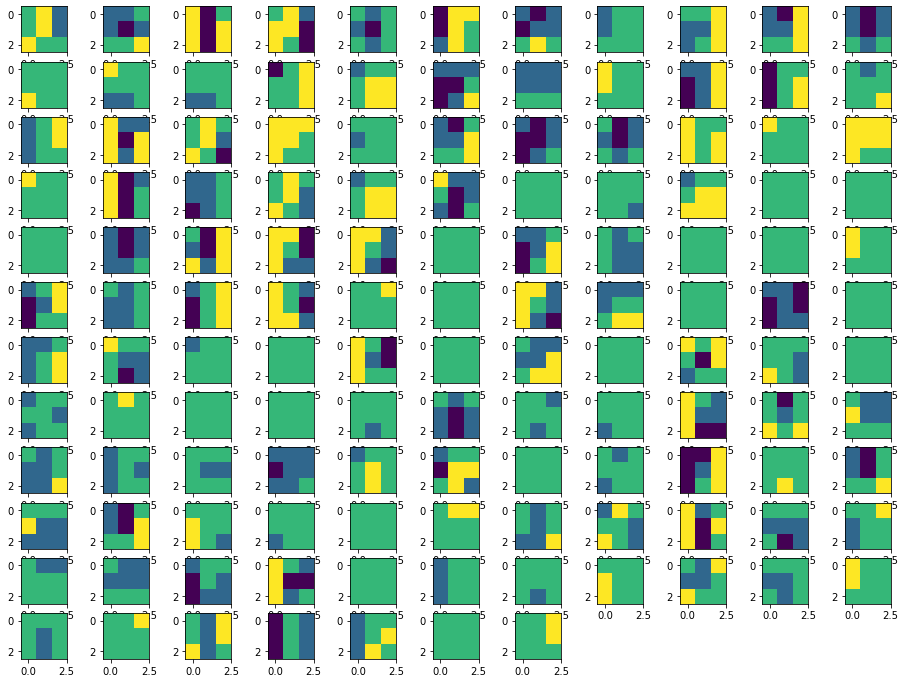

In [29]:
show_tensor(device, valid_data, pact_network, 'features.0')

<a id='sec:fake2true'></a>
## Exporting trained QNNs to integerised ONNX IRs


The network that we have trained is not an integerised program yet.
In particular, not even its input data points have integer components.
Therefore, as a first step along the integerisation pass we need to create `DataLoader`s that emit data points with integer components.

As pointed out earlier, the ground truth files containing CIFAR-10 data points encode images using the RGB colour model.
Each pixel is a triple of 8-bit bytes, each of which encodes the intensity of a different colour channel.
However, `torchvision`'s importer objects scale each value down by a factor of $255$, returning arrays of floating-point numbers in the range $[0, 1]$.
Then, we applied the shift-and-scale normalisation procedure.
These operations involve integer-to-floating casting operations and floating-point operations that are not necessarily precisely invertible: therefore, retrieving the original integer pixel values from the pre-processed floating-point values is likely to be tedious and imprecise.

Therefore, we opted for the following solution: instead of writing our own importer for CIFAR-10 images with integer components and computing analytically the quantum associated with our pre-processing (which would essentially amount to exactly inverting the pre-processing function), we simply add an additional pre-processing step that takes in input the cast-to-floating and shifted-and-scaled pixels, and outputs integerised versions.


In [30]:
def get_input_range(data_loader: torch.utils.data.DataLoader) -> Tuple[float, float]:
    """Traverse the available data set to get the empirical range of input pixels."""
    min_ = 0.0
    max_ = 0.0

    for x, _ in data_loader:
        min_ = min(min_, x.min().item())
        max_ = max(max_, x.max().item())
    
    return min_, max_


def add_quantisation_transform(data_loader: torch.utils.data.DataLoader, n_levels: int, min_: float, max_: float) -> float:
    
    quantiser = qa.pact.PACTAsymmetricAct(n_levels=n_levels, symm=True, learn_clip=False, init_clip='max', act_kind='identity')

    clip_lo, clip_hi       = qa.pact.util.almost_symm_quant(torch.Tensor([max(abs(min_), abs(max_))]), n_levels)
    quantiser.clip_lo.data = clip_lo
    quantiser.clip_hi.data = clip_hi
    
    quantiser.started |= True
    
    transform_list  = []
    transform_list += [data_loader.dataset.transform]
    transform_list += [quantiser]
    transform_list += [transforms.Lambda(lambda x: x / quantiser.get_eps())]
    
    data_loader.dataset.transform = transforms.Compose(transform_list)
    
    return quantiser.get_eps()


In [31]:
n_input_levels = 2**8
min_, max_     = get_input_range(valid_loader)

input_eps = add_quantisation_transform(valid_loader, n_input_levels, min_, max_)


The components of the data points produce by the updated `DataLoader` are 8-bit signed integers (i.e., they are of the `INT8` data type).

We can now proceed to the F2T conversion step.
F2T conversion involves the application of elementary arithmetic properties (distributive, associative) and clever approximations; it also involves potentially complex pattern matching and graph rewriting rules.
In `quantlib`, the functionalities to perform F2T conversions are implemented in two sub-packages:
* `quantlib.editing.graphs`; it is based on PyTorch's graph tracing mechanism and on the Python NetworkX package for graph analysis and manipulation; this is the legacy method: it allows to define custom graph rewriting rules, but to master it the user must be familiar with pattern matching on graphs;
* `quantlib.editing.fx`; in is based on PyTorch's `fx` package, which is dedicated to the manipulation of computational graphs; this is the new method: it allows to define pattern matching rules in a transparent way.


In [32]:
import quantlib.editing.fx as qfx


def f2t_convert(dataloader: torch.utils.data.DataLoader,
                input_eps:  float,
                network:    nn.Module) -> nn.Module:

    network.eval()
    network = network.to(device=torch.device('cpu'))
    
    x, _ = dataloader.dataset.__getitem__(0)
    x    = x.unsqueeze(0)
    
    fake2true_converter = qfx.passes.pact.IntegerizePACTNetPass(shape_in=x.shape, eps_in=input_eps, D=2**19)
    
    return fake2true_converter(pact_network)

#export_net(tq_pact_network,
#           name='VGG_PACT',
#           out_dir='ONNX', eps_in=CIFAR10_STATS_QUANTISE['eps'], integerize=False, D=2**19, in_data=dummy_x)


In [33]:
tq_pact_network = f2t_convert(valid_loader, input_eps, pact_network)

key <class 'torch.nn.modules.batchnorm.BatchNorm2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target pilot.1!
key <class 'torch.nn.modules.batchnorm.BatchNorm2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target features.1!
key <class 'torch.nn.modules.pooling.MaxPool2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target features.3!
key <class 'torch.nn.modules.batchnorm.BatchNorm2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target features.5!
key <class 'torch.nn.modules.batchnorm.BatchNorm2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target features.8!
key <class 'torch.nn.modules.pooling.MaxPool2d'> not found in _EPS_CONVERSIONS!
Using identity epsilon propagation on node with op call_module, target features.10!
key <cla

/home/spmatteo/anaconda3/envs/quantlab/lib/python3.8/site-packages/torch/fx/graph.py:606: UserWarning: Attempted to insert a call_module Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule
  warnings.warn("Attempted to insert a call_module Node with "


A sanity check: we compare the predictions of the fully-integerised program with the ground truth to verify that they are coherent.


In [34]:
x, y_gt_int = valid_loader.dataset.__getitem__(random.randrange(0, len(valid_loader.dataset)))

x = x.unsqueeze(0)
y_pr = tq_pact_network(x)
y_pr_int = y_pr.argmax(axis=1)

print("True: {} - Predicted: {}".format(int2label[y_gt_int], int2label[y_pr_int.item()]))



True: Ship - Predicted: Ship


Once we have performed F2T conversion, we can export the resulting PyTorch `Module` to the ONNX format.
Usually, the ONNX file output by `quantlib` will be taken in input by a platform-specific tool that will perform the deployment, a stage that includes:
* platform-specific graph optimisations;
* platform-specific code generation.

To fulfill this job in an automated and effective way, the backend tool will require the ONNX to be annotated with details such as the precision (in bits) of each parameter and feature array.
To this end, `quantlib` includes several backend-specific packages implementing export functions that can format the ONNX of the integerised network to make it a valid input for the platform-specific deployment tool.


In [35]:
import quantlib.backends as qb


def create_vgg_dir_export(dir_logs: os.PathLike) -> os.PathLike:
    dir_export = os.path.join(dir_logs, 'onnx_exports')
    if not os.path.isdir(dir_export):
        os.makedirs(dir_export, exist_ok=True)
    return dir_export

def export_network(data_loader: torch.utils.data.DataLoader,
                   input_eps:   float,
                   network:     nn.Module,
                   filename:    str,
                   dir_export:  os.PathLike) -> None:
    
    network.eval()
    
    x, _ = data_loader.dataset.__getitem__(random.randrange(0, len(data_loader.dataset)))
    x = x.unsqueeze(0)
    
    qb.dory.export_net(network,
                       name=filename,
                       out_dir=dir_export,
                       eps_in=input_eps,
                       integerize=False,
                       D=2**19,
                       in_data=x)


In [36]:
dir_export = create_vgg_dir_export(dir_logs)
export_network(valid_loader, input_eps, tq_pact_network, 'VGG_PACT_DORY.onnx', dir_export)


Not permuting output of layer output...
Not permuting output of layer classifier._QL_REPLACED__INTEGERIZE_BN1D_UNSIGNED_ACT_PASS_0...
Not permuting output of layer classifier._QL_REPLACED__INTEGERIZE_BN1D_UNSIGNED_ACT_PASS_1...
